# Approach based on density maps generation

In [1]:
import torch
from torch.utils.data import Dataset
import torch.utils.data as data
#from torchvision import datasets
#from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
# Torchvision library
import torchvision
import torch.nn as nn
from tqdm import tqdm # plot progress bars
import numpy as np

import os
import pandas as pd
#from torchvision.io import read_image
from PIL import Image
import seaborn as sns
import copy
import cv2
import random
import time

from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp
import torchvision.transforms.functional as TF

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)


## Data adquisition  definition of the Dataset class and Dataloader

In [3]:
class CustomImageDataset(Dataset):
    """As builsing back the images to the original size is usefull for counting the number of kernels
       I need to pass this information """
    def __init__(self, annotations_file, img_dir,scale, img_transform=None, target_transform=None,geo_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir    = img_dir
        ### Transforms
        self.geo_transform    = geo_transform    #Must be identically applied to images and labels
        self.img_transform    = img_transform
        self.target_transform = target_transform
        self.scale = scale
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path) # I load it as a PIL image so I can perform some transforms that are not available for tensors.
        label_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 2])
        label    = cv2.imread(label_path,flags=cv2.IMREAD_ANYDEPTH)
        ### Threshold the maps
        label[label <= 1e-4] = 0
        ### Scale the maps
        label *= self.scale
        ### Retrieve other usefull information
        shape = label.shape
        count = self.img_labels.iloc[idx, 1]
        
        ### Apply transforms
        # Transforms on images
        if self.img_transform:
            image = self.img_transform(image)
        # Transforms on labels
        if self.target_transform:
            label = self.target_transform(label)
        # Transforms on labels and images
        if self.geo_transform:
            image,label = self.geo_transform([image,label])
        return image, label, shape, count
    

In [4]:
class MyGeometricTransformation(object):
    """Custom transform which appllies exactly the same transforms
       on images and labels, to that purpose we use functional transforms."""
    def __call__(self, x):
        x_ = x[0]
        y_ = x[1]
        if random.random() > 0.5:
            x_ = TF.hflip(x[0])
            y_ = TF.hflip(x[1])
        
        if random.random() > 0.5:
            x_ = TF.vflip(x[0])
            y_ = TF.vflip(x[1])
        
        if random.random() > 0.5:
            x_ = TF.rotate(x[0],15)
            y_ = TF.rotate(x[1],15)
        return x_,y_

In [5]:
### Define loading transforms, after spliting the train set into validation and training we further apply trnasforms

load_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((224,224)),
                                        ])


In [6]:
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"

dataset = "corn"

train_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_train_labels.csv" 
train_data_path = path + f"{dataset}_coco/train_set" 

test_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_test_labels.csv" 
test_data_path = path + f"{dataset}_coco/test_set"


In [7]:
### Define dataset
scale = 1e4
train_dataset = CustomImageDataset(train_csv_path, train_data_path,
                                   scale = scale,
                                   img_transform    = load_transforms,
                                   target_transform = load_transforms,
                                   geo_transform = None)

test_dataset = CustomImageDataset(test_csv_path, test_data_path,
                                  scale = scale,
                                  img_transform    = load_transforms,
                                  target_transform = load_transforms)

In [8]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_dataset) * 0.80)
num_valid_examples = len(train_dataset) - num_train_examples

print(f"Number of training examples: {num_train_examples}")

Number of training examples: 193


In [9]:
# Create 'Subset' objects
train_dataset, validation_dataset = data.random_split(train_dataset, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(validation_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 193
Number validation examples: 49
Number test examples: 62


In [10]:
# Apply test transformations to the validation set
validation_dataset = copy.deepcopy(validation_dataset) # If we change train transformations, this won't affect the validation set
validation_dataset.dataset.transform = load_transforms

In [11]:
# data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)


## Data augmentation

Observe that we didnt apply any data augmentation in the train dataset in order to preserve the validation dataset properties,
now we have to apply the desired transforms on the train dataset.

In [12]:
### Define the data augmentation transforms
train_transforms = transforms.Compose([
                                        #torchvision.transforms.ColorJitter(),
                                        #torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                                        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                        torchvision.transforms.ToTensor(),
                                        transforms.Resize((224,224)),
                                        ])
geometric_transforms = transforms.Compose([
                                        MyGeometricTransformation()
                                        ])


In [13]:
train_dataset.dataset.geo_transform = geometric_transforms
train_dataset.dataset.img_transform = train_transforms

train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0)


Lets check if dataloaders are working properly

In [14]:
start_time = time.time()
train_features, train_labels, shape,count = next(iter(train_dataloader))
end_time = time.time()
print(f"Dataloader Time: {end_time-start_time:.2f} s")

Dataloader Time: 7.10 s


In [15]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

UP = nn.Upsample(size=(shape[0][0],shape[1][0]),mode='bilinear')
img = train_features[0]#.numpy().transpose(1, 2, 0)
img = img[None, :]
img = UP(img)
img = img[0].numpy().transpose(1, 2, 0)

label = train_labels[0]#.numpy().transpose(1, 2, 0)
label = label[None, :]
label = UP(label)
label = label[0].numpy().transpose(1, 2, 0)

print(f"Feature batch shape: {img.shape}")
print(f"Labels batch shape: {label.shape}")

Feature batch shape: torch.Size([50, 3, 224, 224])
Labels batch shape: torch.Size([50, 1, 224, 224])
Feature batch shape: (2309, 1732, 3)
Labels batch shape: (2309, 1732, 1)


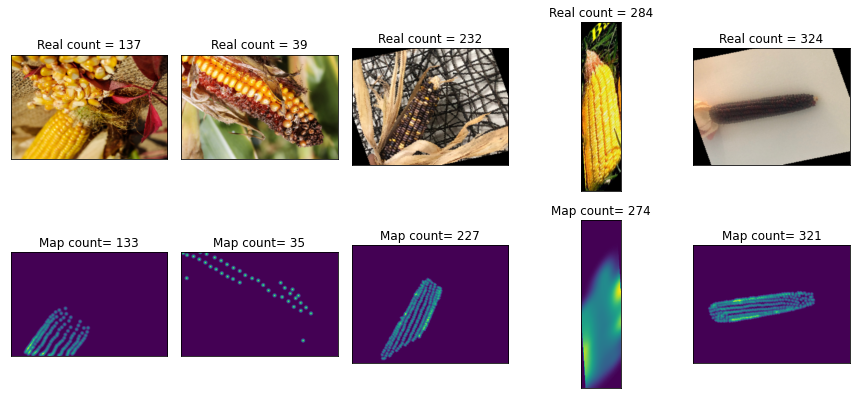

In [16]:
elements = [i for i in range(5,10)]

fig, axs = plt.subplots(2, 5, figsize=(12,6))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(5):
    idx = elements[i]
    ### Move the images to the right shapes
    UP = nn.Upsample(size=(shape[0][idx],shape[1][idx]),mode='bilinear')
    img = train_features[idx]#.numpy().transpose(1, 2, 0)
    img = img[None, :]
    img = UP(img)
    img = img[0].numpy().transpose(1, 2, 0)

    label = train_labels[idx]#.numpy().transpose(1, 2, 0)
    label = label[None, :]
    label = UP(label)
    label = label[0].numpy().transpose(1, 2, 0)
    
    
    # Plot the reconstructed image
    axs[i].imshow(img)
    axs[i].set_title(f"Real count = {count[idx]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+5].imshow(label)
    axs[i+5].set_title(f"Map count= {int(label.sum()/scale)}")
    axs[i+5].set_xticks([])
    axs[i+5].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)

# Network architecture

In [17]:
class Map_CNN(nn.Module):
    def __init__(self, Pre_Trained_Encoder):
        super().__init__()
        
        self.encoder     = Pre_Trained_Encoder
         ### Encoder
        self.decoder = nn.Sequential(  
                       nn.Conv2d(in_channels  = 512,      # C1
                                  out_channels = 256,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),                    
                        nn.Conv2d(in_channels  = 256,     # C2    
                                  out_channels = 128,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True), 
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 128,     #C3  
                                  out_channels = 64,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 64,      #C4  
                                  out_channels = 1,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 1,       #C5
                                  out_channels = 1,
                                  kernel_size  = 1,
                                  padding = 0,
                                  stride = 1)
            )
        
    def forward(self, x,mode):
        if (mode == "Train"):
            self.encoder.train()
            self.decoder.train()
        elif (mode == "Test"):
            self.encoder.eval()
            self.decoder.eval()
        y = self.encoder(x)
        y = self.decoder(y)
        return y
    
    
    def train_epoch(self,device,dataloader, loss_fn, optimizer):
        """
        This function train the network for one epoch
        """
        # Train
        loss_list = []
        for x, y,_,_ in dataloader:
            # Move data to device
            x = x.to(device)
            y = y.to(device)
            # Forward
            y_pred = self.forward(x,"Train")
            # Compute loss
            loss = loss_fn(y_pred, y)
            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            #Updata weights
            optimizer.step()
            # Save batch loss
            loss_list.append(loss.detach().cpu().numpy())
        return np.mean(loss_list)

    def validate_epoch(self,device, dataloader, loss_fn):
        """
        This function validate/test the network performance for one epoch of training
        """
        loss_list = []
        # Discable gradient tracking
        with torch.no_grad():
            for x, y,_,_ in dataloader:
                x = x.to(device)
                y = y.to(device)
                y_pred = self.forward(x,"Test")
                loss = loss_fn(y_pred, y)
                loss_list.append(loss.detach().cpu().numpy()) 
        return np.mean(loss_list)
       
    def training_cycle(self, device, training_iterator, test_iterator, loss_fn, optim, num_epochs,
                       verbose= True):
        """
        This function train the network for a desired number of epochs it also test the network 
        reconstruction performance and make plots comparing the input image and the reconstructed one every 5 epochs.
        """
        #initialize the tensorboard writer
        #writer = SummaryWriter()
        #I keep track of losses for plots
        train_loss = []
        val_loss  = []
        for epoch in tqdm(range(num_epochs)):
            start_time = time.time()
            ### Training (use the training function)
            tr_l = self.train_epoch(device=device, 
                                    dataloader=training_iterator, 
                                    loss_fn=loss_fn, 
                                    optimizer=optim)
            train_loss.append(tr_l)
            writer.add_scalar("Loss/train", tr_l, epoch)
            
            ### Validation  (use the testing function)
            v_l = self.validate_epoch(device=device, 
                                      dataloader=test_iterator, 
                                      loss_fn=loss_fn)
            val_loss.append(v_l)
            writer.add_scalar("Loss/validation", v_l, epoch)
            end_time = time.time()
            writer.flush()
            if verbose:
                print(f"\nEpoch: {epoch+1}/{num_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
                print("---------------------------------")
                print(f"Train -- Loss: {tr_l:.3f}")
                print(f"Val -- Loss: {v_l:.3f}")
        return train_loss, val_loss
    


Prepare pre trained model for backbone and define our model

In [18]:
### Load pretrained model
VGG16 = smp.Unet('vgg16', encoder_weights='imagenet')
### Load weights
#VGG16.load_state_dict(torch.load('C:/Users/hilar/.cache/torch/hub/checkpoints/vgg16-397923af.pth'))
### Define the encoder
backbone = VGG16.encoder.features[0:20]
### Define the model
model = Map_CNN(backbone)

In [19]:
# ### Load pretrained model
# VGG16 = torchvision.models.vgg16(pretrained = True)
# ### Load weights
# #VGG16.load_state_dict(torch.load('C:/Users/hilar/.cache/torch/hub/checkpoints/vgg16-397923af.pth'))
# ### Define the encoder
# enc = VGG16.features[0:20]
# ### Define the model
# model = Map_CNN(enc)

In [20]:
### Disable the weight update for the trained encoder
for param_name, param in model.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in model.decoder.parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
for param_name, param in model.named_parameters():
    print(param_name,param.requires_grad)

encoder.0.weight False
encoder.0.bias False
encoder.2.weight False
encoder.2.bias False
encoder.5.weight False
encoder.5.bias False
encoder.7.weight False
encoder.7.bias False
encoder.10.weight False
encoder.10.bias False
encoder.12.weight False
encoder.12.bias False
encoder.14.weight False
encoder.14.bias False
encoder.17.weight False
encoder.17.bias False
encoder.19.weight False
encoder.19.bias False
decoder.0.weight True
decoder.0.bias True
decoder.2.weight True
decoder.2.bias True
decoder.5.weight True
decoder.5.bias True
decoder.8.weight True
decoder.8.bias True
decoder.11.weight True
decoder.11.bias True


In [21]:
max_epochs        = 20
learning_rate     = 1e-3

In [22]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
model.to(device)

Selected device: cpu


Map_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [23]:
writer = SummaryWriter(f"./runs/geo_augmentation_lr_{learning_rate}_epochs_{max_epochs}_scale_{scale}_threshold_{1e-4}14")
train_loss, test_loss = model.training_cycle(device,
                                train_dataloader,
                                validation_dataloader,
                                loss_fn,
                                optimizer,
                                max_epochs,
                                verbose=True)
### To end TensorBoard writings
writer.close()

  5%|████                                                                              | 1/20 [01:40<31:54, 100.79s/it]


Epoch: 1/20 -- Epoch Time: 100.78 s
---------------------------------
Train -- Loss: 1052.758
Val -- Loss: 401.042


 10%|████████▎                                                                          | 2/20 [03:11<28:32, 95.15s/it]


Epoch: 2/20 -- Epoch Time: 91.19 s
---------------------------------
Train -- Loss: 551.752
Val -- Loss: 369.688


 15%|████████████▍                                                                      | 3/20 [04:42<26:20, 92.95s/it]


Epoch: 3/20 -- Epoch Time: 90.33 s
---------------------------------
Train -- Loss: 538.854
Val -- Loss: 354.499


 20%|████████████████▌                                                                  | 4/20 [06:13<24:33, 92.12s/it]


Epoch: 4/20 -- Epoch Time: 90.86 s
---------------------------------
Train -- Loss: 496.245
Val -- Loss: 328.312


 25%|████████████████████▊                                                              | 5/20 [07:43<22:49, 91.32s/it]


Epoch: 5/20 -- Epoch Time: 89.88 s
---------------------------------
Train -- Loss: 451.158
Val -- Loss: 286.900


 30%|████████████████████████▉                                                          | 6/20 [09:14<21:18, 91.31s/it]


Epoch: 6/20 -- Epoch Time: 91.28 s
---------------------------------
Train -- Loss: 384.886
Val -- Loss: 249.055


 35%|█████████████████████████████                                                      | 7/20 [10:46<19:48, 91.44s/it]


Epoch: 7/20 -- Epoch Time: 91.71 s
---------------------------------
Train -- Loss: 323.878
Val -- Loss: 309.106


 40%|█████████████████████████████████▏                                                 | 8/20 [12:18<18:19, 91.63s/it]


Epoch: 8/20 -- Epoch Time: 92.03 s
---------------------------------
Train -- Loss: 295.435
Val -- Loss: 213.342


 45%|█████████████████████████████████████▎                                             | 9/20 [13:50<16:49, 91.78s/it]


Epoch: 9/20 -- Epoch Time: 92.09 s
---------------------------------
Train -- Loss: 243.611
Val -- Loss: 210.069


 50%|█████████████████████████████████████████                                         | 10/20 [15:19<15:11, 91.16s/it]


Epoch: 10/20 -- Epoch Time: 89.79 s
---------------------------------
Train -- Loss: 215.580
Val -- Loss: 208.220


 55%|█████████████████████████████████████████████                                     | 11/20 [16:49<13:37, 90.79s/it]


Epoch: 11/20 -- Epoch Time: 89.95 s
---------------------------------
Train -- Loss: 206.706
Val -- Loss: 170.837


 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:19<12:03, 90.46s/it]


Epoch: 12/20 -- Epoch Time: 89.70 s
---------------------------------
Train -- Loss: 178.641
Val -- Loss: 134.232


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:50<10:33, 90.52s/it]


Epoch: 13/20 -- Epoch Time: 90.64 s
---------------------------------
Train -- Loss: 167.711
Val -- Loss: 172.522


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:20<09:01, 90.32s/it]


Epoch: 14/20 -- Epoch Time: 89.85 s
---------------------------------
Train -- Loss: 135.625
Val -- Loss: 116.765


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [22:50<07:31, 90.38s/it]


Epoch: 15/20 -- Epoch Time: 90.52 s
---------------------------------
Train -- Loss: 138.848
Val -- Loss: 142.320


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [24:22<06:03, 90.88s/it]


Epoch: 16/20 -- Epoch Time: 92.05 s
---------------------------------
Train -- Loss: 136.770
Val -- Loss: 126.407


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [25:53<04:32, 90.71s/it]


Epoch: 17/20 -- Epoch Time: 90.31 s
---------------------------------
Train -- Loss: 119.125
Val -- Loss: 118.023


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:22<03:00, 90.44s/it]


Epoch: 18/20 -- Epoch Time: 89.79 s
---------------------------------
Train -- Loss: 114.784
Val -- Loss: 130.745


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:48<03:05, 92.72s/it]


KeyboardInterrupt: 

In [56]:
### Save model
os.makedirs('./Models', exist_ok=True)
torch.save(model.state_dict(), f'Models/geo_augmentation_lr_{learning_rate}_epochs_{max_epochs}_scale_{scale}14.pth')

In [26]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

NameError: name 'train_loss' is not defined

<Figure size 504x360 with 0 Axes>

# Testing

In [27]:
# Load network parameters
model.load_state_dict(torch.load(f'Models/geo_augmentation_lr_{learning_rate}_epochs_{max_epochs}_scale_{scale}12.pth'))

<All keys matched successfully>

In [24]:
### Evaluation on test set
with torch.no_grad():
    for data in test_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, shapes, counts = data
        inputs = inputs.to(device)
        # forward 
        outputs = model(inputs, "Test")


### Statistics on the test set

In [25]:
idx = 2
input_image = inputs.detach().cpu().numpy()[idx]
predicted_map = outputs[idx]
original_map = labels[idx]

print("Predicted map:")
print("Shape",predicted_map.shape)
print("Min", predicted_map.min())
print("Maxp",predicted_map.max())
print("")
print("Original map:")
print("Shape",original_map.shape)
print("Min",original_map.min())
print("Maxp",original_map.max())

Predicted map:
Shape torch.Size([1, 224, 224])
Min tensor(-0.4049)
Maxp tensor(3.5800)

Original map:
Shape torch.Size([1, 224, 224])
Min tensor(0.)
Maxp tensor(24.5207)


Basically it is predicting all as 0 and thats why it is achieving such a low loss, so i will enlarge it to get better results.

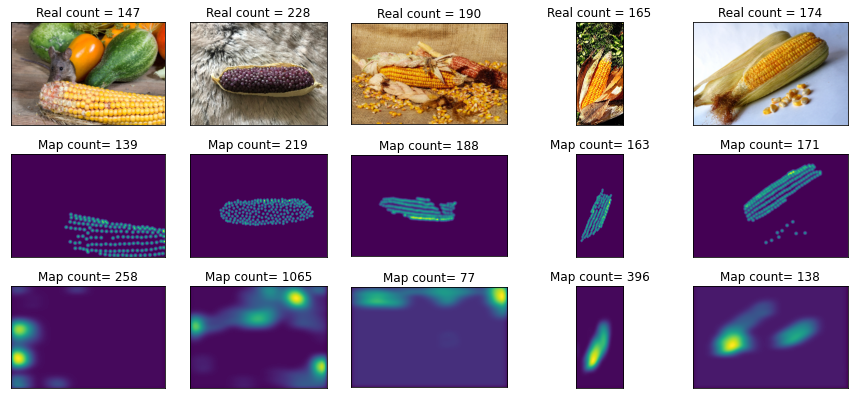

In [26]:
elements = [0,1,2,3,4]#random.sample([i for i in range(len(test_dataset))], 5)

fig, axs = plt.subplots(3, 5, figsize=(12,6))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(5):
    idx = elements[i]
    ### Move the images to the right shapes
    UP = nn.Upsample(size=(shapes[0][idx],shapes[1][idx]),mode='bilinear')
    img = inputs[idx]#.numpy().transpose(1, 2, 0)
    img = img[None, :]
    img = UP(img)
    img = img[0].numpy().transpose(1, 2, 0)

    label = labels[idx]#.numpy().transpose(1, 2, 0)
    label = label[None, :]
    label = UP(label)
    label = label[0].numpy().transpose(1, 2, 0)
    
    map_ = outputs[idx]#.numpy().transpose(1, 2, 0)
    map_ = map_[None, :]
    map_ = UP(map_)
    map_ = map_[0].numpy().transpose(1, 2, 0) 
    
    # Plot the reconstructed image
    axs[i].imshow(img)
    axs[i].set_title(f"Real count = {counts[idx]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+5].imshow(label)
    axs[i+5].set_title(f"Map count= {int(label.sum()/scale)}")
    axs[i+5].set_xticks([])
    axs[i+5].set_yticks([])
    axs[i+10].imshow(map_)
    axs[i+10].set_title(f"Map count= {int(map_.sum()/scale)}")
    axs[i+10].set_xticks([])
    axs[i+10].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)

### Evaluation metrics

In [61]:
label_count_list = []
map_count_list = []
for idx in [i for i in range(len(test_dataset))]:
    ### Move the images to the right shapes
    UP = nn.Upsample(size=(shapes[0][idx],shapes[1][idx]),mode='bilinear')

    label = labels[idx]#.numpy().transpose(1, 2, 0)
    label = label[None, :]
    label = UP(label)
    label = label[0].numpy().transpose(1, 2, 0)
    label_count = int(label.sum()/scale)
    label_count_list.append(label_count)
    
    map_ = outputs[idx]#.numpy().transpose(1, 2, 0)
    map_ = map_[None, :]
    map_ = UP(map_)
    map_ = map_[0].numpy().transpose(1, 2, 0) 
    map_count = int(map_.sum()/scale)
    map_count_list.append(map_count)

In [62]:
mae = np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list)))/len(map_count_list)
print("MAE = ", mae)

rmse = np.sqrt(np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list))**2)/len(map_count_list))
print("RMSE = ", rmse)

MAE =  340.0
RMSE =  609.4975191142714


In [40]:
labels[:,0,:,:].shape

torch.Size([62, 224, 224])

In [ ]:
def mae():
    return 